In [317]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier



from scipy import stats
from prettytable import PrettyTable

In [318]:
data = pd.read_csv('data.csv')

Function for scores and ROC curve with corss-validation

In [319]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [320]:
class_names = ['Breast Cancer Deaths',
    'COVID-19 Deaths',
    'Cardiovascular Disease Deaths',
    'Diabetes Deaths',
    'Drug Overdose Deaths',
    'Firearm Deaths',
    'HIV-Related Deaths',
    'Heart Disease Deaths',
    'Infant Deaths',
    'Injury Deaths',
    'Lung Cancer Deaths',
    'Maternal Deaths',
    'Motor Vehicle Deaths',
    'Opioid Overdose Deaths',
    'Pneumonia or Influenza Deaths',
    ]

In [321]:
def perso_roc(test, X, y, class_names):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=15, method='predict_proba')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')


### Feature Selection with Correlation based method

In [322]:
corr_matrix = data.corr()

In [323]:
correlation_with_target = corr_matrix['metric_item_label'].abs().sort_values(ascending=False)
selected_features_corr = correlation_with_target[:15].index.tolist()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

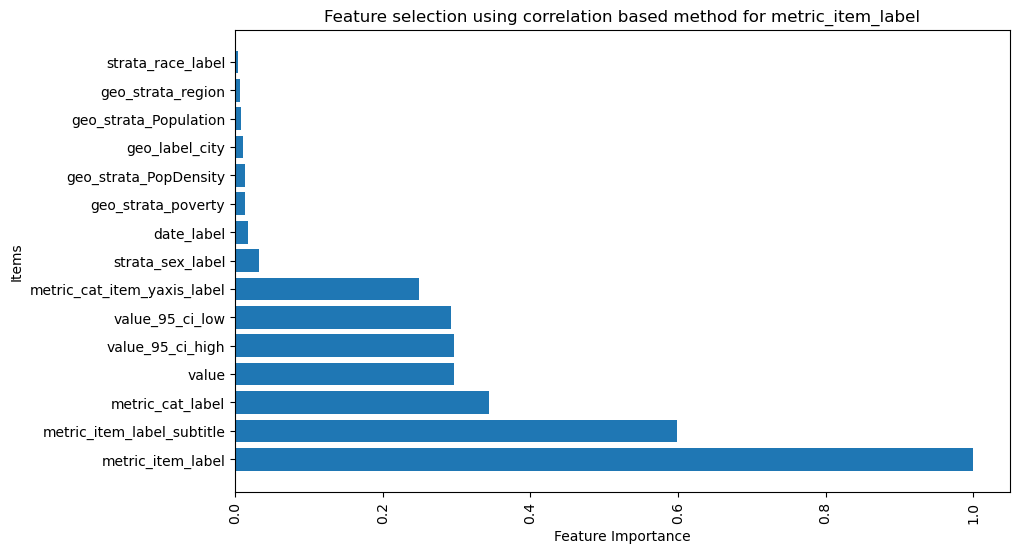

In [324]:
plt.figure(figsize=(10, 6))
plt.barh(selected_features_corr, correlation_with_target[selected_features_corr])
plt.xlabel('Feature Importance')
plt.ylabel('Items')
plt.title('Feature selection using correlation based method for metric_item_label')
plt.xticks(rotation=90)

Selected the 25 best features

In [325]:
selected_features_corr = data[selected_features_corr].columns.tolist()

### Random Forest Model

In [326]:
X = data[selected_features_corr]
y = data['metric_item_label']

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Changing Hyperparamters

In [328]:
RF = RandomForestClassifier(n_estimators=8, max_depth=10, max_samples=9, class_weight='balanced')
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [329]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')

In [330]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.2612
Precision: 0.24100524066181198
Recall: 0.2612
F1 Score: 0.199994901722121


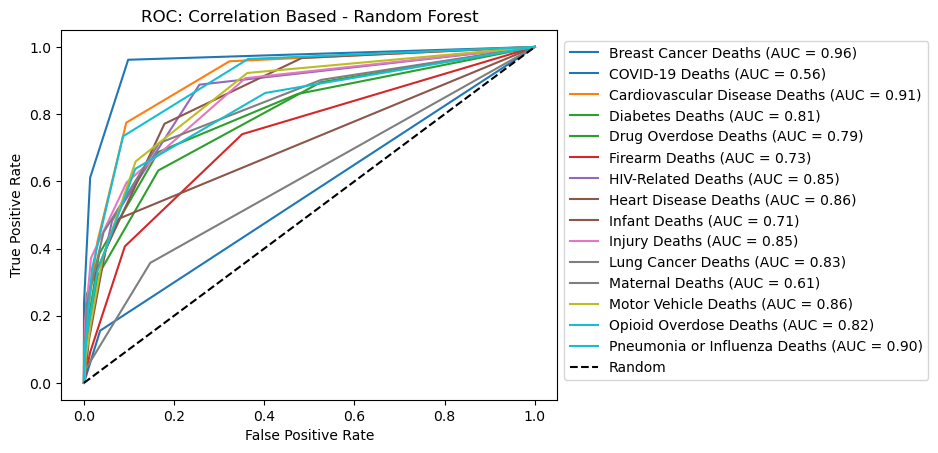

In [331]:
perso_roc(RF, X, y, class_names)
plt.title('ROC: Correlation Based - Random Forest')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Logistic Regression Model

In [332]:
LogReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5, penalty='l2', class_weight='balanced')

In [333]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

In [334]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')


In [335]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.2898
Precision: 0.34616760717559975
Recall: 0.2898
F1 Score: 0.2647586798436683


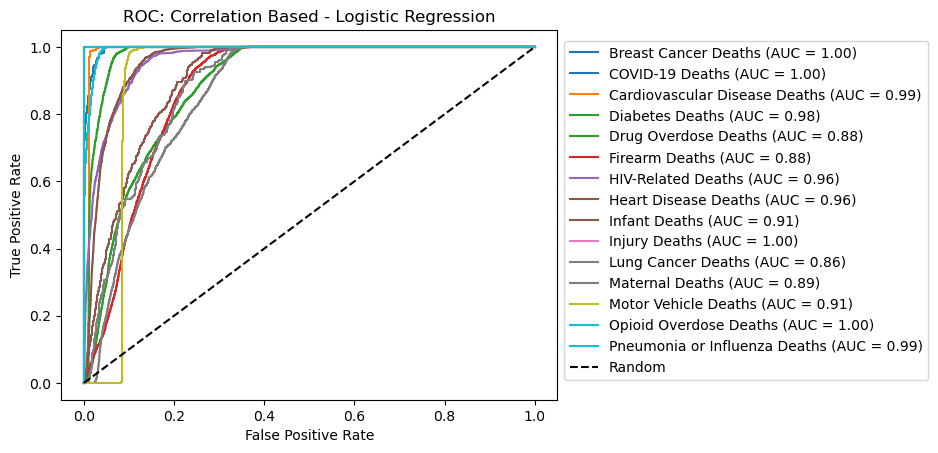

In [336]:
perso_roc(LogReg, X, y, class_names)
plt.title('ROC: Correlation Based - Logistic Regression')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Decision Tree Model

In [337]:
DT = DecisionTreeClassifier(max_depth=2, min_samples_split=30, max_features=2)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [338]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

In [339]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.3312
Precision: 0.1738690733760302
Recall: 0.3312
F1 Score: 0.2148715683931585


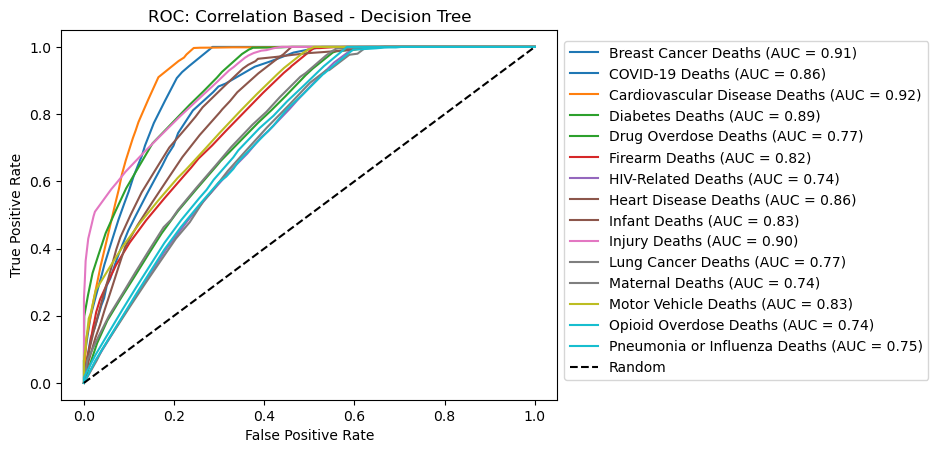

In [340]:
perso_roc(DT, X, y, class_names)
plt.title('ROC: Correlation Based - Decision Tree')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Using KNN model

In [341]:
knn = KNeighborsClassifier(n_neighbors=7000, algorithm='ball_tree')


In [342]:
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

y_pred_proba_knn = knn.predict_proba(X_test) 

auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr')

In [343]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.3266
Precision: 0.19725326871239393
Recall: 0.3266
F1 Score: 0.2093760987053646


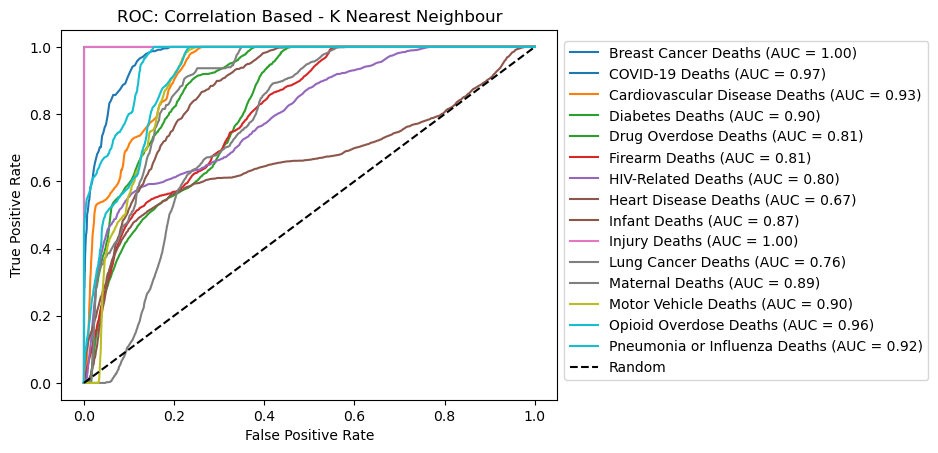

In [344]:
perso_roc(knn, X, y, class_names)
plt.title('ROC: Correlation Based - K Nearest Neighbour')
plt.legend(bbox_to_anchor=(1, .99), loc='upper left')


### Scores

In [345]:
model_names = ['RF', 'LogReg', 'KNN', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

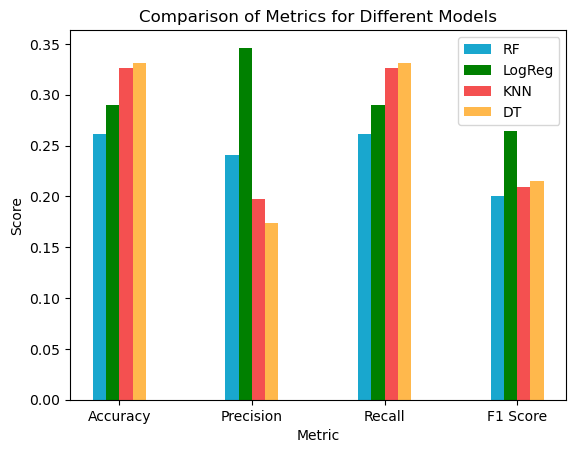

In [346]:
x = np.arange(len(metric_names))

bar_width = 0.1

color_map = {'RF': '#19A7CE', 'LogReg': 'green', 'KNN': '#F45050', 'DT': '#FFB84C'}

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name, color=color_map[model_name])

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

Random Forest AUC: 0.7038920096321094
Decision Tree AUC: 0.8053314122149193
Logistic Regression AUC: 0.945050916783954
KNN AUC: 0.858225013482455


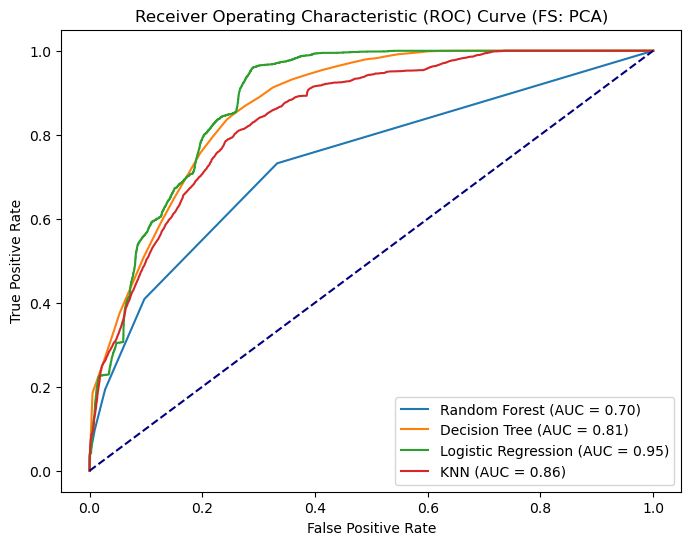

In [347]:
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_rf.ravel())
print(f"Random Forest AUC: {auc_RF}")

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_DT.ravel())
print(f"Decision Tree AUC: {auc_DT}")

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_LR.ravel())
print(f"Logistic Regression AUC: {auc_LogReg}")

# SVC
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_proba_knn.ravel())
print(f"KNN AUC: {auc_knn}")


# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_RF:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_DT:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_LogReg:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (FS: PCA)')
plt.legend(loc='lower right')
